<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Helper-functions" data-toc-modified-id="Helper-functions-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Helper functions</a></span></li><li><span><a href="#Loading-data-and-preprocessing" data-toc-modified-id="Loading-data-and-preprocessing-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Loading data and preprocessing</a></span></li><li><span><a href="#EDA" data-toc-modified-id="EDA-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>EDA</a></span></li><li><span><a href="#Dropping-NaN-variables" data-toc-modified-id="Dropping-NaN-variables-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Dropping NaN variables</a></span></li><li><span><a href="#EDA" data-toc-modified-id="EDA-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>EDA</a></span><ul class="toc-item"><li><span><a href="#Movies-EDA" data-toc-modified-id="Movies-EDA-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Movies EDA</a></span></li></ul></li><li><span><a href="#MERGE-ALL" data-toc-modified-id="MERGE-ALL-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>MERGE ALL</a></span></li></ul></div>

In [678]:
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import pandas as pd
import plotly
import bokeh
import requests
import seaborn as sns

from collections import Counter

`pd.__version__` must be at least 0.25.0 to run the [explode()](https://pandas.pydata.org/pandas-docs/version/0.25/user_guide/reshaping.html#exploding-a-list-like-column) functions.

If not, run `!pip install pandas --upgrade`.

In [679]:
pd.__version__

'0.25.0'

In [680]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)
pd.set_option('plotting.backend', 'matplotlib')
pd.options.display.float_format = '{:.2f}'.format

%matplotlib inline
plt.style.use('fivethirtyeight')

%config InlineBackend.figure_format ='retina'

In [9]:
#Initalise global data frames
books = pd.DataFrame()
movies = pd.DataFrame()
books_s1 = pd.DataFrame()
movies_s1 = pd.DataFrame()

books_ex = pd.DataFrame()
movies_ex = pd.DataFrame()
merge_ex = pd.DataFrame()

books_ex_save = pd.DataFrame()
movies_ex_save = pd.DataFrame()
merge_ex_save = pd.DataFrame()

initial_books, initial_movies = 0, 0 
df_status = {}
error_log = []

## Helper functions

In [10]:
def get_shapes():
    """
    Updates df_status and returns the dictionary.
    """

    global df_status

    df_status = {'books': books.shape,
                 'books_s1': books_s1.shape,
                 'movies': movies.shape,
                 'movies_s1': movies_s1.shape,
                 'books_ex': books_ex.shape,
                 'books_ex_save': books_ex_save.shape,
                 'movies_ex': movies_ex.shape,
                 'movies_ex_save': movies_ex_save.shape,
                 'merge_ex': merge_ex.shape,
                 'merge_ex_save': merge_ex_save.shape,
                 'initial_books': initial_books,
                 'initial_movies': initial_movies}

    return df_status

In [11]:
def save(get_shape=False):
    """
    Saves current state of data frames for easy access. 
    Run before methods that critically update dataframes.

    Args: 
        get_shape: (default: False) returns get_shape() if True.
    """

    global books_s1
    global movies_s1
    global books_ex_save
    global movies_ex_save
    global merge_ex_save

    books_s1 = books.copy(deep=True)
    movies_s1 = movies.copy(deep=True)

    books_ex_save = books_ex.copy(deep=True)
    movies_ex_save = movies_ex.copy(deep=True)
    merge_ex_save = merge_ex.copy(deep=True)

    print('\nDataframes saved.')
    if get_shape:
        return get_shapes()


def restore(get_shape=False):
    """
    Restores data frames from last save state.

    Args: 
        get_shape: (default: False) returns get_shape() if True.
    """

    global books
    global movies
    global books_ex
    global movies_ex
    global merge_ex

    books = books_s1.copy(deep=True)
    movies = movies_s1.copy(deep=True)

    books_ex = books_ex_save.copy(deep=True)
    movies_ex = movies_ex_save.copy(deep=True)
    merge_ex = merge_ex_save.copy(deep=True)

    print('\nDataframes recovered.')
    if get_shape:
        return get_shapes()

In [12]:
def read_data():
    """
    Reads from csv files.
    """

    global books
    global movies
    global initial_books
    global initial_movies

    books = pd.read_csv('data/books.csv')
    movies = pd.read_csv('data/movies.csv')
    
    books = books.round(4)
    movies = movies.round(4)
    
    initial_books = books.shape
    initial_movies = movies.shape

    print("'books.csv' and 'movies.csv' have been read with shapes: {} and {}".format(
        books.shape, movies.shape))

In [13]:
def lowercase_dfs():
    """
    Converts columns to str and changes them to lowercase.
    """
    
    global books
    global movies
    
    global error_log
    local_errors = 0
    
    nan_to_string = ['author', 'title']

    for col_name in nan_to_string:
        try:
            books[col_name][books[col_name].isnull()] = ''
            movies[col_name][movies[col_name].isnull()] = ''
        except KeyError as e:
            error_log.append({'lowercase_dfs()': e})
            local_errors += 1
            pass
        
    books = books.applymap(lambda c:c.lower().strip() if type(c) == str else c)
    movies = movies.applymap(lambda c:c.lower().strip() if type(c) == str else c)
    
    print('\nDataframes lowercased with {} errors.'.format(local_errors))

In [14]:
def clean_dates():
    """
    Convert str dates to datetime objects.
    """

    global error_log
    local_errors = 0

    try:
        books['gc_text_reviews_count'] = books['gc_text_reviews_count'] + 1
        books['publish_date'] = pd.to_datetime(books['publish_date'])
        books['publish_year'] = books['publish_date'].dt.year

        movies['imdb_released'] = pd.to_datetime(movies['imdb_released'])
    except ValueError or AttributeError as e:
        error_log.append({'clean_dates() --> to_datetime': e})
        local_errors += 1
        pass

    try:
        books.drop(columns=['book_wiki_url', 'adaptations',
                            'title', 'gc_title'], inplace=True)
    except KeyError as e:
        error_log.append({'clean_dates() --> drop cols': e})
        local_errors += 1
        pass
    
    movies['imdb_year'] = movies['imdb_year'].str[:4]
    movies['imdb_year'] = movies['imdb_year'].astype('float')
    
    try:
        movies['imdb_runtime'] = movies['imdb_runtime'].str[:-4]
        movies['imdb_runtime'] = movies['imdb_runtime'].astype('float')
    except ValueError:
        pass
    
   

    print('\nDates cleaned with {} errors.'.format(local_errors))

In [15]:
def merge_rows():
    global books
    global movies

    books = books.groupby(['book_id']).agg('max').reset_index()
    movies = movies.groupby(['movie_id']).agg('max').reset_index()
    print("\nRows merged by book_id and movie_id with shapes: {} and {}".format(
        books.shape, movies.shape))

In [16]:
def str_to_list(df, list_of_columns):
    """
    Runs list_clean() for a list of columns in a particular dataframe. 
    """
    for col in list_of_columns:
        df[col] = df[col].apply(list_clean, convert_dtype=True)

    print('\n', list_of_columns, 'is cleaned.')


def list_clean(str_list):
    """
    Converts a list in str form to a list seperated by ','.
    """

    str_list = str(str_list)
    cleaned_list = str_list.replace("'", '').replace(
        '[', '').replace(']', '').replace('"', '')
    cleaned_list = [element.strip() for element in cleaned_list.split(',')]

    if len(cleaned_list) == 1:
        if 'nan' in cleaned_list:
            cleaned_list = None
        else:
            cleaned_list = cleaned_list[0]

    return cleaned_list

list_clean("['secret service', 'world war, 1939-1945', 'fiction']")

['secret service', 'world war', '1939-1945', 'fiction']

In [284]:
def get_missing_authors():
    missing_author = list(books['isbn'].loc[books['author'] == ''])
    fix = False
    for isbn in missing_author:
        curl = 'https://openlibrary.org/api/books?bibkeys=ISBN:{}&jscmd=data&format=json'.format(isbn)
        all_metadata = requests.get(curl).json()
        try:
            author = all_metadata['ISBN:{}'.format(isbn)]['authors'][0]['name']
            books['author'].loc[books['isbn'] == isbn] = author
            print(author)
            fix = True
        except KeyError:
            pass
    if fix:
        print('\nSome missing authors have been restored.')

In [17]:
def real_prices():
    global movies
    
    t_inflation = pd.read_csv('data/ticket_inflation.csv')
    g_inflation = pd.read_csv('data/general_inflation.csv')
    g_inflation = g_inflation.astype(float)
    t_inflation = t_inflation.astype(float)
    g_inflation = g_inflation.merge(t_inflation, on = 'imdb_year')

    movies = movies.merge(g_inflation, on = 'imdb_year')

    for col in ['opening_weekend_usa', 'gross_usa']:
        movies[col + '_2010_dollars'] = movies[col]/movies['ticket_inflation_rate']
    movies['budget_2010_dollars'] = movies['budget']/movies['general_inflation_rate']

    print('Prices converted to 2010 dollars.')

In [18]:
def get_dtype_summary(df):
    """
    Augmented data type summary.
    """
    
    w = pd.DataFrame(df.dtypes, columns=['dtype']).rename_axis('keys')
    x = pd.DataFrame(df.isnull().sum(), columns= ['null_count']).rename_axis('keys')
    y = pd.DataFrame(df.isnull().sum()/len(df), columns= ['null_percent']).rename_axis('keys')
    z = pd.DataFrame(df.count(), columns = ['non_null_count']).rename_axis('keys')
    w = w.merge(x.merge(y.merge(z, on = 'keys'), on = 'keys'), on = 'keys')
    print(w)

## Loading data and preprocessing

In [285]:
error_log = []
read_data()
get_missing_authors()
lowercase_dfs()
merge_rows()

str_to_list(books, ['subjects', 'subject_places', 'publish_places'])
str_to_list(movies, ['imdb_actors', 'imdb_writers', 'imdb_genres'])

clean_dates()
real_prices()

save(True)

'books.csv' and 'movies.csv' have been read with shapes: (769, 24) and (660, 23)

Dataframes lowercased with 2 errors.


/Users/chan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




Rows merged by book_id and movie_id with shapes: (685, 24) and (595, 23)

 ['subjects', 'subject_places', 'publish_places'] is cleaned.

 ['imdb_actors', 'imdb_writers', 'imdb_genres'] is cleaned.

Dates cleaned with 0 errors.
Prices converted to 2010 dollars.

Dataframes saved.


{'books': (685, 21),
 'books_s1': (685, 21),
 'movies': (484, 28),
 'movies_s1': (484, 28),
 'books_ex': (0, 0),
 'books_ex_save': (0, 0),
 'movies_ex': (0, 0),
 'movies_ex_save': (0, 0),
 'merge_ex': (0, 0),
 'merge_ex_save': (0, 0),
 'initial_books': (769, 24),
 'initial_movies': (660, 23)}

## EDA

In [269]:
books.columns

Index(['book_id', 'author', 'book_title', 'count', 'isbn', 'oclc', 'valid_identifier', 'metadata_updated', 'number_of_pages', 'subject_places', 'subjects', 'publish_date', 'publish_places', 'goodreads', 'gc_language_code', 'gc_average_rating', 'gc_format', 'gc_ratings_count', 'gc_text_reviews_count', 'gc_authors', 'publish_year'], dtype='object')

In [270]:
books.describe()

,count,number_of_pages,goodreads,gc_average_rating,gc_ratings_count,gc_text_reviews_count,publish_year
count,685.00,448.00,411.00,407.00,407.00,407.00,506.00
mean,0.21,312.66,2340351.11,3.91,32022.06,1004.34,1988.64
std,0.41,154.90,6693672.10,0.24,250485.06,6857.09,18.98
min,0.00,30.00,1296.00,3.16,0.00,1.00,1847.00
25%,0.00,213.75,325113.00,3.76,36.50,6.00,1980.00
50%,0.00,282.00,894416.00,3.91,258.00,31.00,1993.00
75%,0.00,384.00,1466490.00,4.08,1350.00,136.00,2001.00
max,1.00,1096.00,46011367.00,4.56,4389911.00,93813.00,2017.00


In [271]:
get_dtype_summary(books)

                                dtype  null_count  null_percent  non_null_count
keys                                                                           
book_id                        object           0          0.00             685
author                         object           0          0.00             685
book_title                     object           0          0.00             685
count                           int64           0          0.00             685
isbn                           object         123          0.18             562
oclc                           object         173          0.25             512
valid_identifier                 bool           0          0.00             685
metadata_updated                 bool           0          0.00             685
number_of_pages               float64         237          0.35             448
subject_places                 object         399          0.58             286
subjects                       object   

In [273]:
get_dtype_summary(movies)

                                           dtype  null_count  null_percent  non_null_count
keys                                                                                      
movie_id                                  object           0          0.00             484
movie_title                               object           0          0.00             484
book_title                                object           0          0.00             484
imdb_no                                   object           0          0.00             484
usable                                      bool           0          0.00             484
isbn                                     float64         174          0.36             310
oclc                                      object         103          0.21             381
imdb_title                                object           0          0.00             484
imdb_actors                               object           0          0.00             484

## Dropping NaN variables

In [287]:
books.drop(columns=['gc_authors', 'count', 'goodreads'], inplace= True)
movies = movies.loc[movies['imdb_runtime'].astype(str).str.isnumeric()]
movies['imdb_runtime'] = movies['imdb_runtime'].astype(int)
save(True)


Dataframes saved.


{'books': (685, 18),
 'books_s1': (685, 18),
 'movies': (475, 28),
 'movies_s1': (475, 28),
 'books_ex': (0, 0),
 'books_ex_save': (0, 0),
 'movies_ex': (0, 0),
 'movies_ex_save': (0, 0),
 'merge_ex': (0, 0),
 'merge_ex_save': (0, 0),
 'initial_books': (769, 24),
 'initial_movies': (660, 23)}

## EDA

In [275]:
GREEN = '#4BF03F'
YELLOW = '#FCE312'
ORANGE = '#FDA44E'
PINK = '#E266FD'
VIOLET = '#5A1EFD'
BROWN = '#1F0E1C'
SKYBLUE = '#61ECF0'
WHITE = '#F0F0F0'
RED = '#F03939'

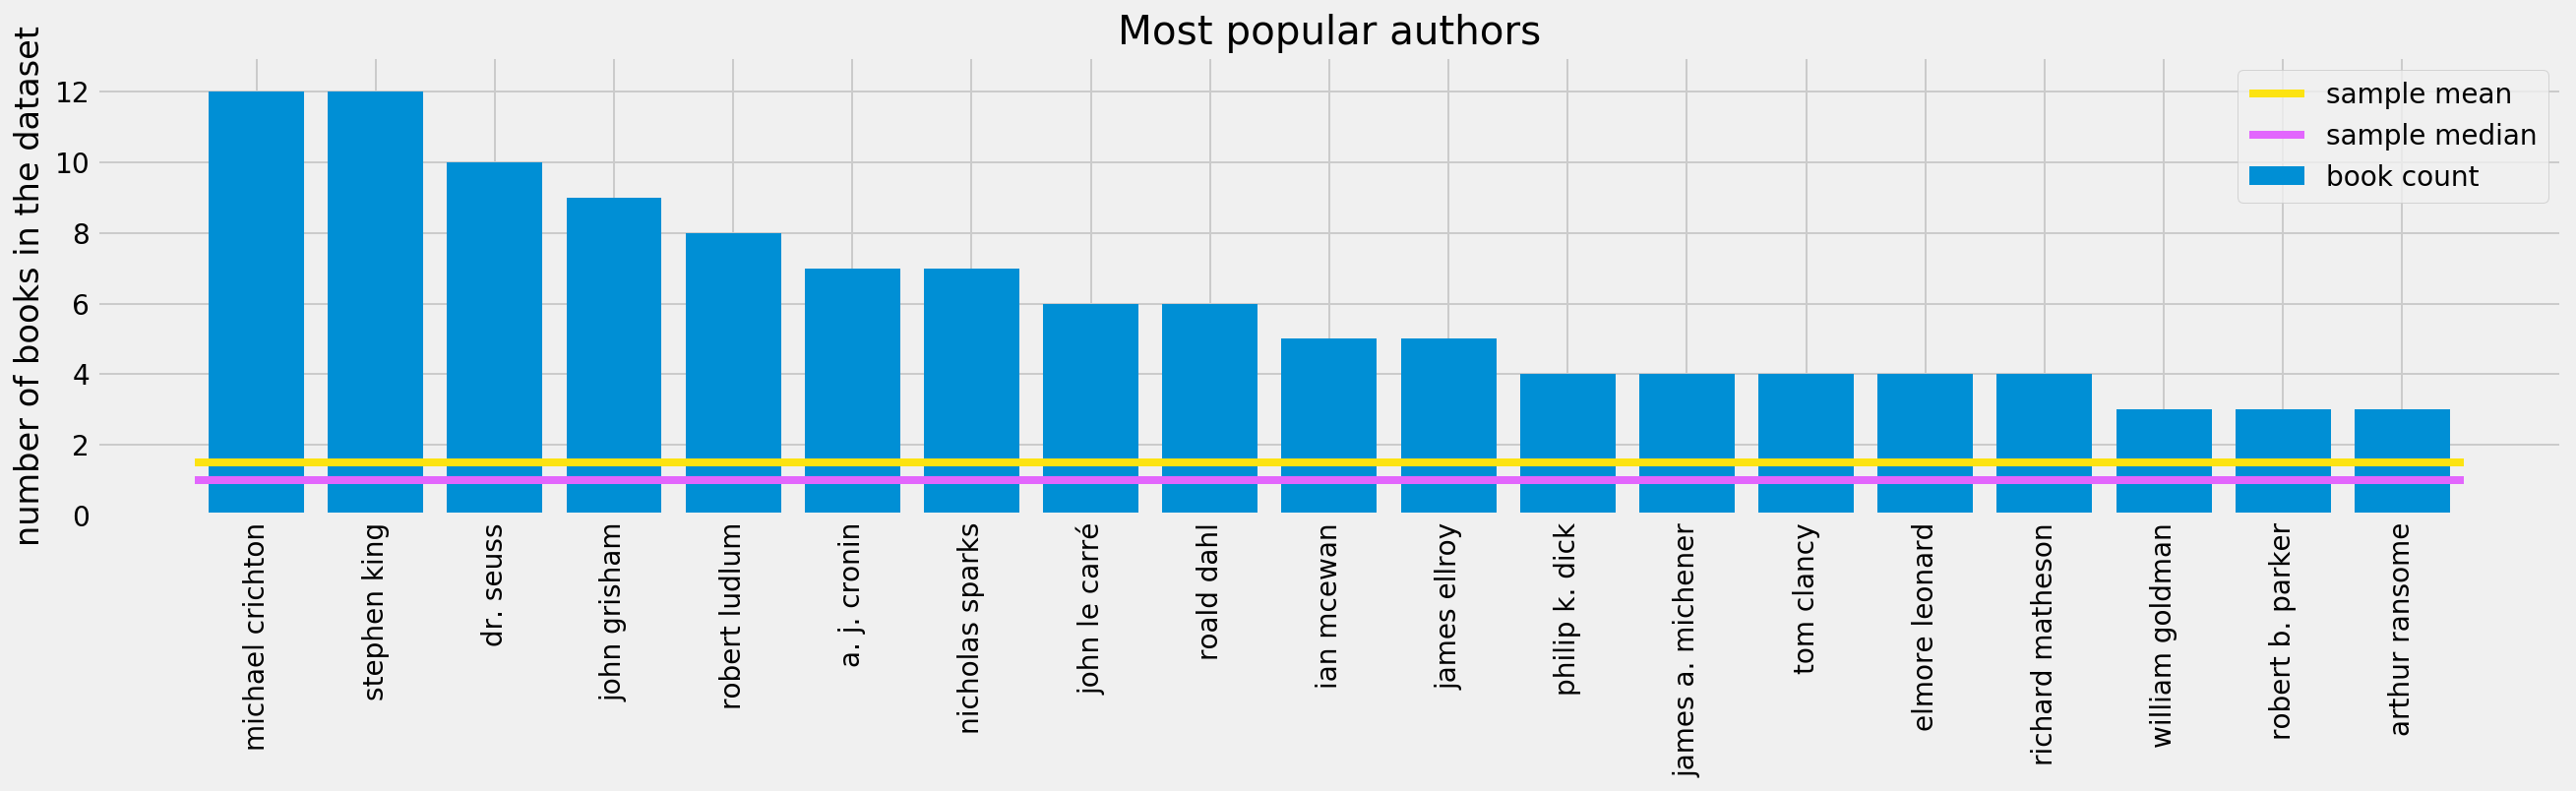

In [290]:
top_authors = books['author'].value_counts()[1:20]
plt.figure(figsize=(20, 4))
plt.bar(x=top_authors.index, height=top_authors.values, label='book count')
plt.xticks(rotation=90)
plt.ylabel('number of books in the dataset')
plt.ylim([0, 13])
plt.axhline(np.nanmean(books['author'].value_counts()),
            label='sample mean', c=YELLOW, xmin=.04, xmax=.96)
plt.axhline(np.nanmedian(books['author'].value_counts(
)), label='sample median', c=PINK, xmin=.04, xmax=.96)
plt.legend()
plt.title('Most popular authors')
plt.show()

/Users/chan/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning:

invalid value encountered in greater_equal

/Users/chan/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning:

invalid value encountered in less_equal



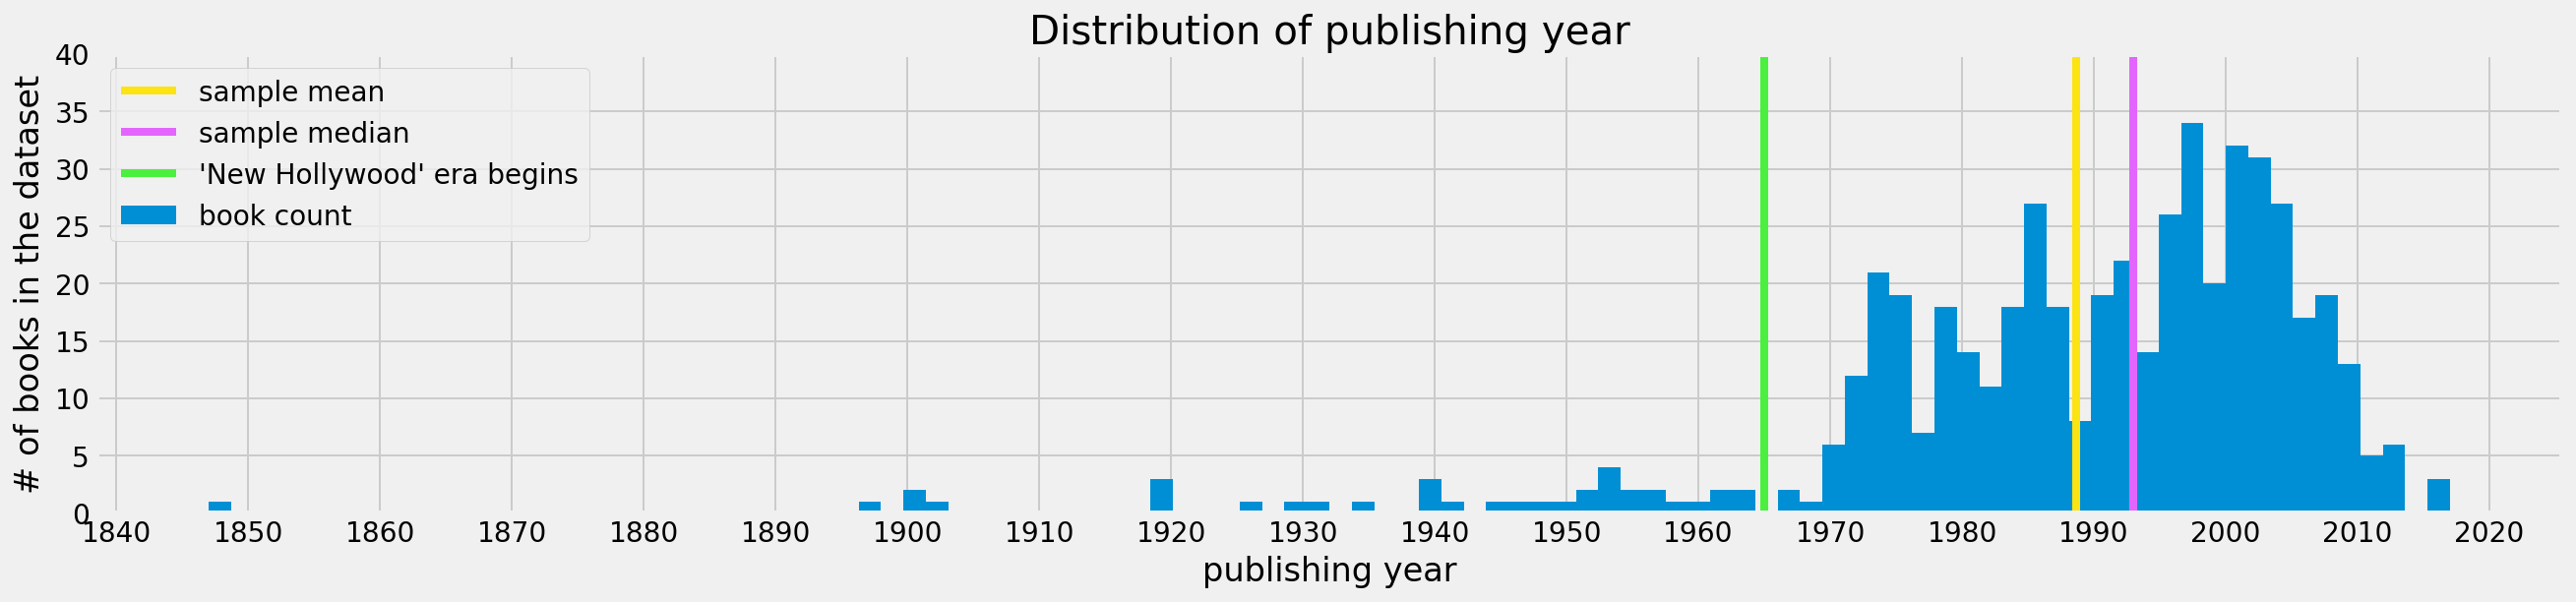

In [291]:
plt.figure(figsize = (20, 4))

plt.axvline(x = np.nanmean(books['publish_year']), c = YELLOW, label = 'sample mean')
plt.axvline(x = np.nanmedian(books['publish_year']), c = PINK, label = 'sample median')
plt.axvline(x = 1965, c = GREEN, label = "'New Hollywood' era begins")
plt.hist(x = books['publish_year'], bins= 100, label='book count')
plt.ylim([0, 40])
plt.xticks(ticks=range(1840, 2030, 10))
plt.xlabel('publishing year')
plt.ylabel('# of books in the dataset')
plt.title('Distribution of publishing year', pad = 5)
plt.legend()
plt.show()

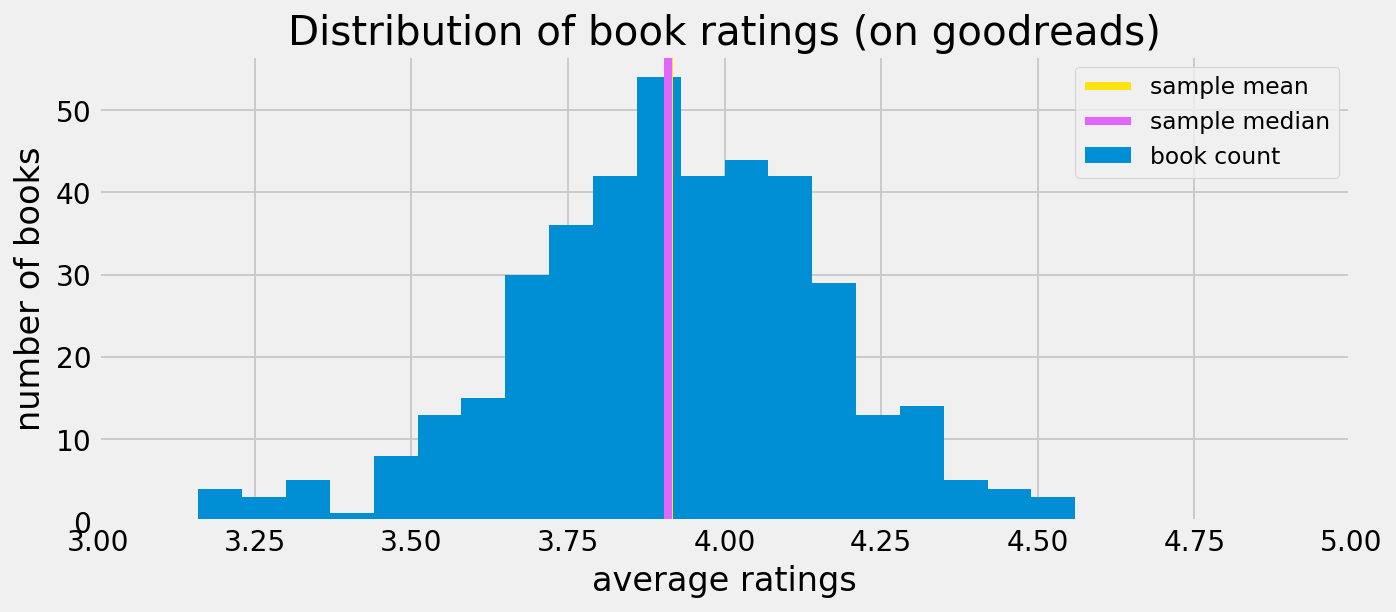

In [293]:
plt.figure(figsize = (10, 4))

plt.axvline(x = np.nanmean(books['gc_average_rating']), c = YELLOW, label = 'sample mean')
plt.axvline(x = np.nanmedian(books['gc_average_rating']), c = PINK, label = 'sample median')
plt.hist(x = books['gc_average_rating'], bins= 20, label='book count')
plt.xlabel('average ratings')
plt.ylabel('number of books')
plt.xlim([3, 5])
plt.title('Distribution of book ratings (on goodreads)', pad = 5)
plt.legend(fontsize = 'small')
plt.show()

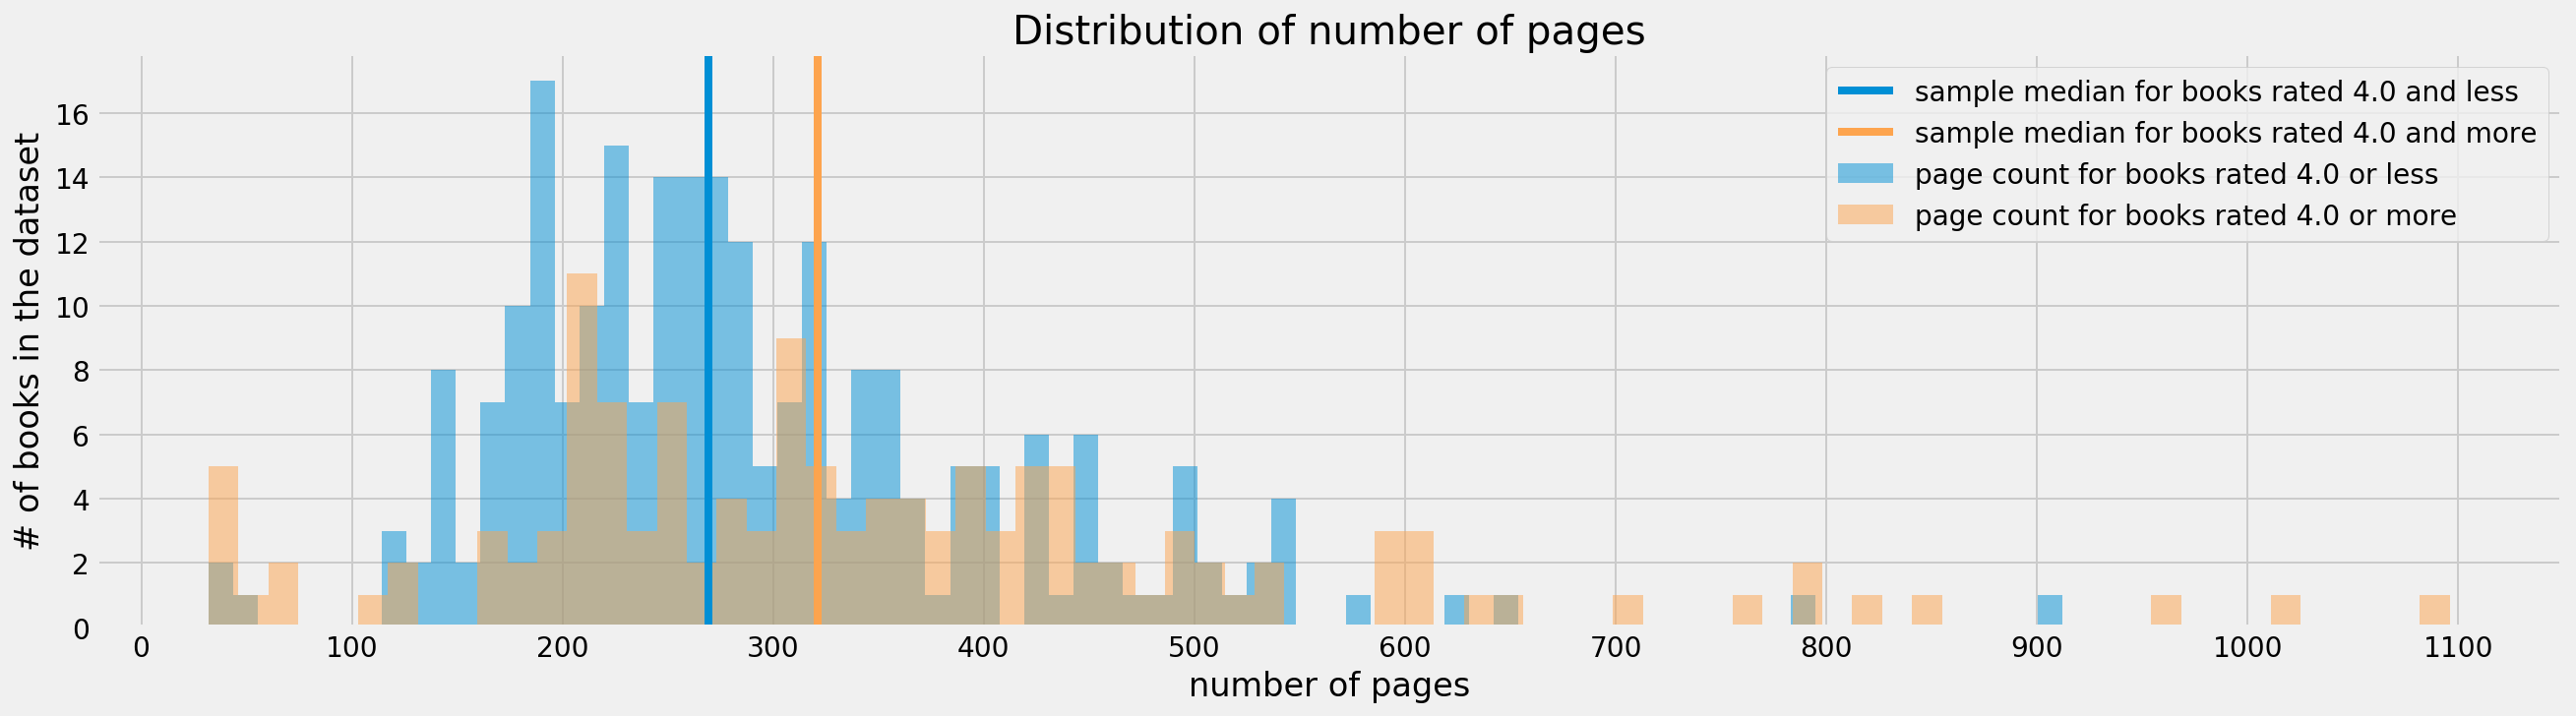

In [294]:
good_books = books.loc[books['gc_average_rating'] > 4]
meh_books = books.loc[books['gc_average_rating'] <= 4]

plt.figure(figsize=(20, 5))
plt.hist(x=meh_books['number_of_pages'],
         bins=75, label='page count for books rated 4.0 or less', alpha=0.5)
plt.hist(x=good_books['number_of_pages'], bins=75,
         label='page count for books rated 4.0 or more', color=ORANGE, alpha=0.5)
plt.xlabel('number of pages')
plt.ylabel('# of books in the dataset')
plt.axvline(x=np.nanmedian(meh_books['number_of_pages']),
            label='sample median for books rated 4.0 and less')
plt.axvline(x=np.nanmedian(good_books['number_of_pages']),
            c=ORANGE, label='sample median for books rated 4.0 and more')
plt.title('Distribution of number of pages', pad = 5)
plt.xticks(range(0, 1200, 100))
plt.legend()
plt.show()

In [474]:
subjects = books.explode('subjects')
vc = subjects['subjects'].value_counts() > 10
vc_true = [s for s in vc.index if vc[s] != False]
subjects = subjects.loc[subjects['subjects'].isin(vc_true)]
x = subjects.groupby(by = 'subjects')['gc_average_rating', 'publish_year'].median()
x.sort_values(by = 'gc_average_rating', ascending = False)[:30]

,gc_average_rating,publish_year
subjects,,
fantasy fiction,4.22,1998.00
juvenile literature,4.20,1989.50
fantasy,4.16,1998.00
new york times bestseller,4.13,2005.00
magic,4.13,1998.00
orphans,4.13,1998.50
ficción juvenil,4.07,1995.00
childrens stories,4.07,1982.50
history,4.04,1991.50


### Movies EDA

In [57]:
movies.columns

Index(['movie_id', 'movie_title', 'book_title', 'imdb_no', 'usable', 'isbn', 'oclc', 'imdb_title', 'imdb_actors', 'imdb_writers', 'imdb_genres', 'imdb_year', 'imdb_rated', 'imdb_released', 'imdb_runtime', 'imdb_imdbrating', 'imdb_imdbvotes', 'metadata_updated', 'book_id', 'budget', 'gross_usa', 'cumulative_worldwide_gross', 'opening_weekend_usa', 'general_inflation_rate', 'ticket_inflation_rate', 'opening_weekend_usa_2010_dollars', 'gross_usa_2010_dollars', 'budget_2010_dollars'], dtype='object')

In [58]:
movies.describe()

,isbn,imdb_year,imdb_runtime,imdb_imdbrating,budget,gross_usa,cumulative_worldwide_gross,opening_weekend_usa,general_inflation_rate,ticket_inflation_rate,opening_weekend_usa_2010_dollars,gross_usa_2010_dollars,budget_2010_dollars
count,305.00,475.00,475.00,472.00,267.00,257.00,170.00,217.00,475.00,475.00,217.00,257.00,267.00
mean,3143122793496.73,1992.38,112.68,6.56,45334242.67,76663575.76,256818457.61,21726973.90,0.65,0.59,26922758.60,112245969.74,54572277.57
std,4574631128826.91,16.40,41.19,1.21,49661854.37,93490918.02,272800776.02,28989234.93,0.31,0.30,33454506.39,131838729.71,49922919.07
min,2.00,1948.00,12.00,1.80,5000.00,13600.00,2500.00,2519.00,0.11,0.05,4328.18,23367.70,6060.61
25%,394481992.00,1980.00,93.00,5.90,10000000.00,12870569.00,69446862.50,1502231.00,0.38,0.34,2650219.76,21913882.87,17844842.63
50%,684801221.00,1997.00,105.00,6.70,25000000.00,40226215.00,148085223.00,9169779.00,0.74,0.58,15271089.90,72386058.98,36798528.06
75%,9780374480127.00,2005.00,127.00,7.50,63000000.00,100478608.00,323298905.75,27537244.00,0.90,0.81,34380028.39,144280539.27,76653860.57
max,9789510430866.00,2019.00,384.00,8.90,250000000.00,436471036.00,1119929521.00,161125000.00,1.17,1.16,156432038.83,872828125.00,254065040.65


In [69]:
top_movies = movies.loc[movies['imdb_imdbrating'] >= 8]
meh_movies = movies.loc[movies['imdb_imdbrating'] < 8]

/Users/chan/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning:

invalid value encountered in greater_equal

/Users/chan/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning:

invalid value encountered in less_equal



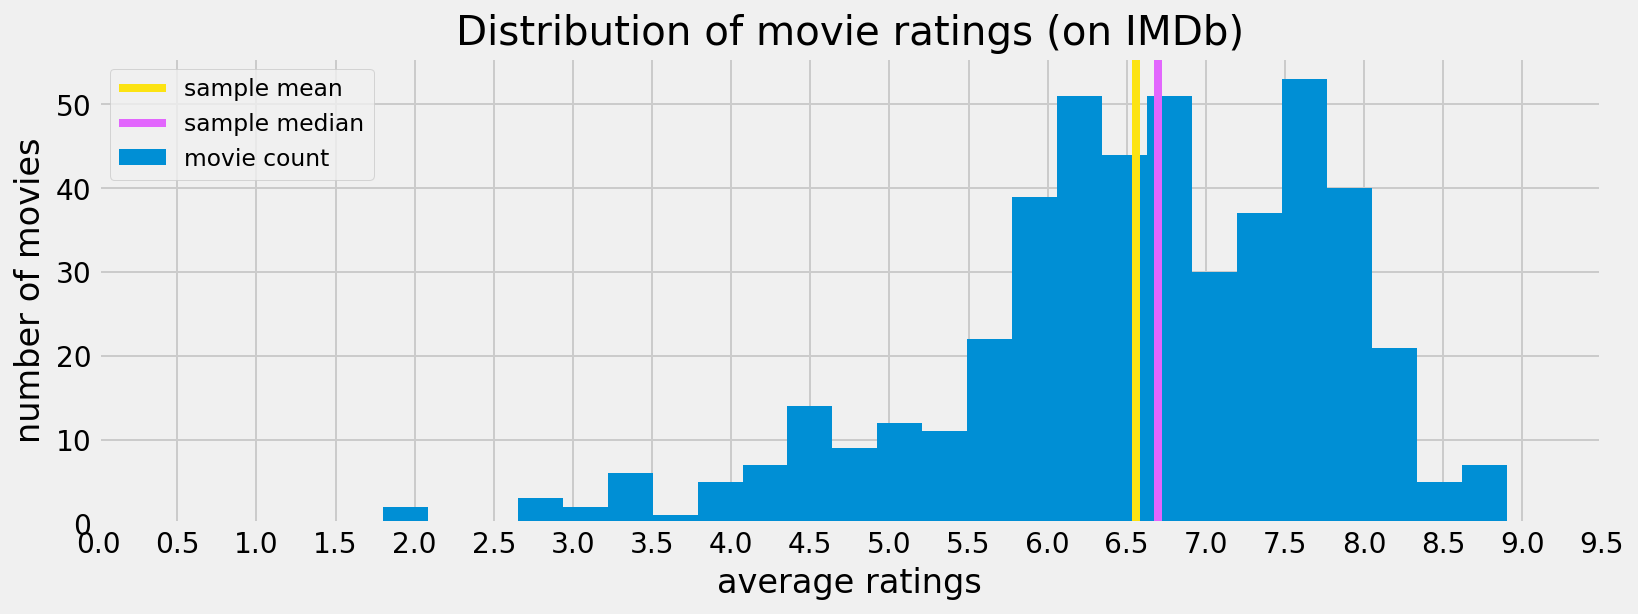

In [166]:
plt.figure(figsize = (12, 4))

plt.axvline(x = np.nanmean(movies['imdb_imdbrating']), c = YELLOW, label = 'sample mean')
plt.axvline(x = np.nanmedian(movies['imdb_imdbrating']), c = PINK, label = 'sample median')
plt.hist(x = movies['imdb_imdbrating'], bins= 25, label='movie count')
plt.xlabel('average ratings')
plt.ylabel('number of movies')
plt.xticks(np.arange(0, 10, 0.5))
plt.title('Distribution of movie ratings (on IMDb)')
plt.legend(fontsize = 'small')
plt.show()

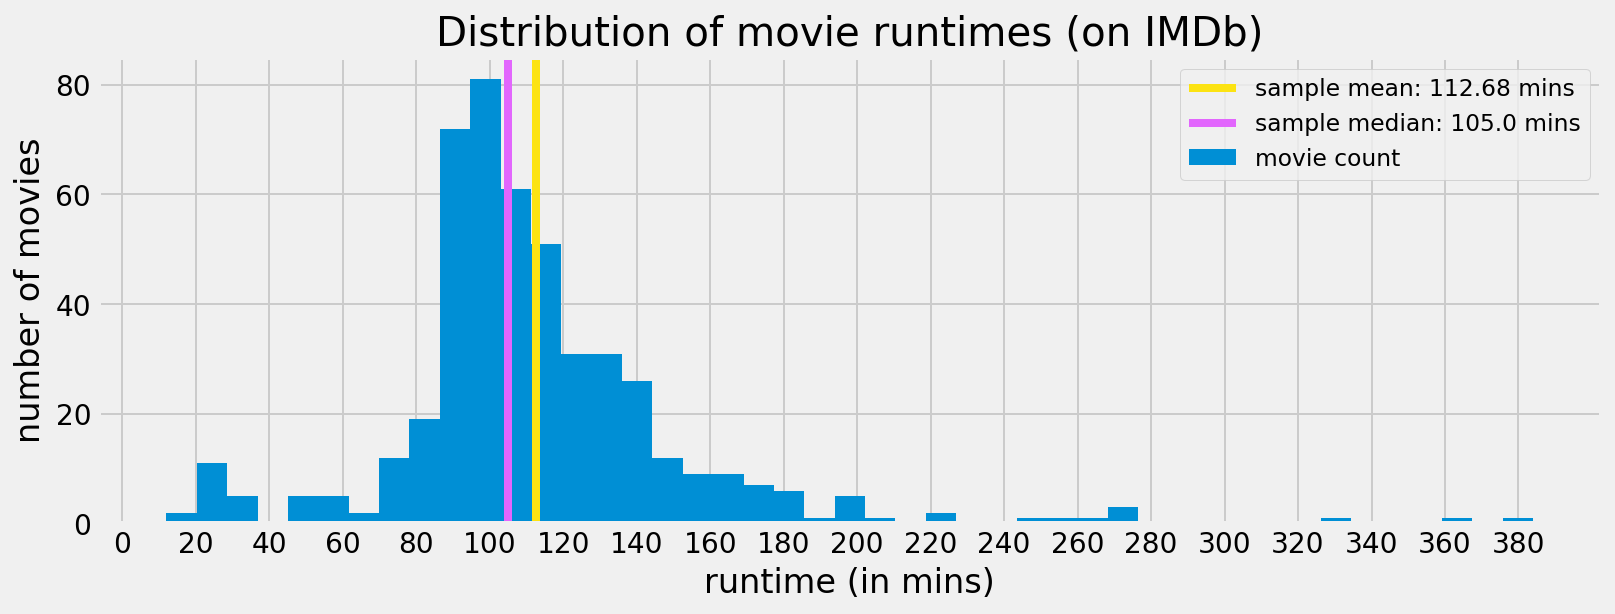

In [165]:
plt.figure(figsize=(12, 4))

plt.axvline(x=np.nanmean(movies['imdb_runtime']), c=YELLOW,
            label='sample mean: {} mins'.format(np.nanmean(movies['imdb_runtime'])))
plt.axvline(x=np.nanmedian(movies['imdb_runtime']), c=PINK, label='sample median: {} mins'.format(
    np.nanmedian(movies['imdb_runtime'])))
plt.hist(x=movies['imdb_runtime'], bins=45, label='movie count')
plt.xlabel('runtime (in mins)')
plt.ylabel('number of movies')
plt.xticks(ticks=range(0, 400, 20))
plt.title('Distribution of movie runtimes (on IMDb)')
plt.legend(fontsize = 'small')
plt.show()

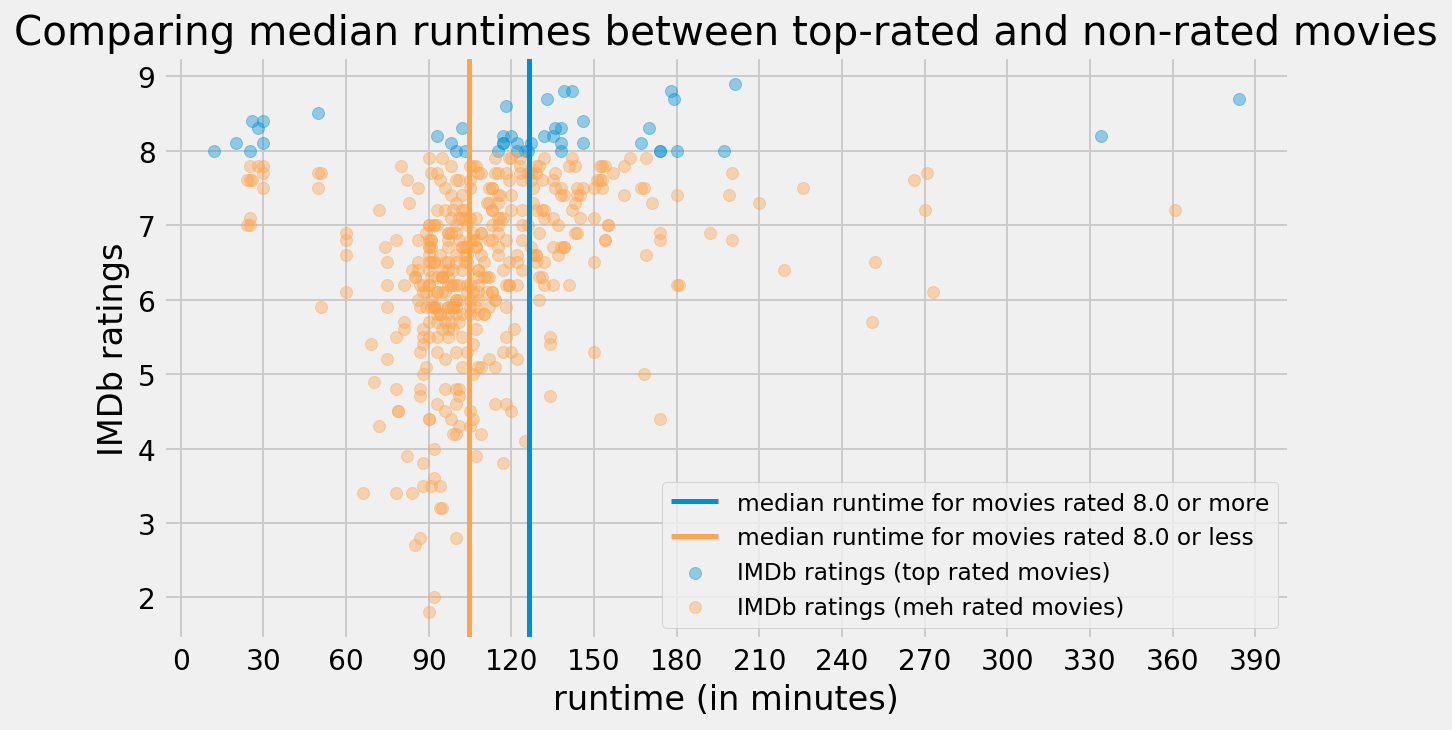

In [164]:
g1 = plt.figure(figsize=(9, 5))
plt.scatter(x=top_movies['imdb_runtime'], y=(top_movies['imdb_imdbrating']),
            label='IMDb ratings (top rated movies)', alpha = 0.4)
plt.scatter(x=meh_movies['imdb_runtime'], y=(meh_movies['imdb_imdbrating']),
            label='IMDb ratings (meh rated movies)', alpha= 0.4, color = ORANGE)
plt.axvline(x=np.median(top_movies['imdb_runtime']),
            label='median runtime for movies rated 8.0 or more', lw = 2.5)
plt.axvline(x=np.median(meh_movies['imdb_runtime']),
            label='median runtime for movies rated 8.0 or less', color=ORANGE, lw = 2.5)

plt.ylabel('IMDb ratings')
plt.xlabel('runtime (in minutes)')
plt.title('Comparing median runtimes between top-rated and non-rated movies')
plt.xticks(range(0, 400, 30))
plt.legend(fontsize = 'small')
plt.show()

In [500]:
def actor_profile(name):
    return actors[['movie_title', 'imdb_year', 'imdb_actors', 'imdb_imdbrating', 'gross_usa_2010_dollars']
       ].loc[actors['imdb_actors'] == name]
    
name = 'daniel radcliffe'
actor_profile(name)

,movie_title,imdb_year,imdb_actors,imdb_imdbrating,gross_usa_2010_dollars
66,harry potter and the half-blood prince,2009.00,daniel radcliffe,7.60,317517557.31
191,harry potter and the chamber of secrets,2002.00,daniel radcliffe,7.40,355962611.41
234,harry potter and the order of the phoenix,2007.00,daniel radcliffe,7.50,334867818.81
318,harry potter and the goblet of fire,2005.00,daniel radcliffe,7.70,357158911.33
355,harry potter and the prisoner of azkaban,2004.00,daniel radcliffe,7.90,316847175.35


In [477]:
actors = movies.explode('imdb_actors')
actors = actors[['movie_title', 'imdb_actors', 'imdb_year',
                 'imdb_imdbrating', 'gross_usa_2010_dollars', 'cumulative_worldwide_gross']]
actors.dropna(subset=['movie_title', 'imdb_actors',
                      'imdb_imdbrating', 'gross_usa_2010_dollars'], inplace=True)

vc = actors['imdb_actors'].value_counts() > 2
vc_true = [a for a in vc.index if vc[a] != False]
actors = actors.loc[actors['imdb_actors'].isin(vc_true)]
x = actors.groupby(by='imdb_actors').mean()

In [478]:
x.sort_values(by='gross_usa_2010_dollars', ascending=False)[:10]

,imdb_year,imdb_imdbrating,gross_usa_2010_dollars,cumulative_worldwide_gross
imdb_actors,,,,
sean astin,2002.00,8.80,466692020.00,972502318.67
jeff goldblum,1989.33,7.33,414731202.28,823896440.50
cameron diaz,2005.50,6.88,383517087.54,738951751.25
jennifer lawrence,2013.33,7.10,360152283.23,737578649.33
sam neill,1995.50,7.05,343450786.35,446332724.25
daniel radcliffe,2005.40,7.62,336470814.84,889376335.40
mike myers,2005.00,6.28,333292540.45,617953509.20
eddie murphy,2003.00,6.25,324105825.11,566017985.67
ken stott,2013.00,7.70,265878338.62,979163403.67


no deathly hallows

In [479]:
x.sort_values(by = 'imdb_imdbrating', ascending = False)[:10]

,imdb_year,imdb_imdbrating,gross_usa_2010_dollars,cumulative_worldwide_gross
imdb_actors,,,,
sean astin,2002.00,8.80,466692020.00,972502318.67
jennifer connelly,2002.33,8.00,83346377.15,111918035.67
russell crowe,2000.33,7.97,157367446.86,217256797.33
jack nicholson,1978.67,7.90,198337768.49,44376625.00
ken stott,2013.00,7.70,265878338.62,979163403.67
ian mckellen,2011.50,7.70,210485284.35,768262559.25
richard armitage,2013.00,7.70,265878338.62,979163403.67
martin freeman,2013.00,7.70,265878338.62,979163403.67
ewan mcgregor,2002.67,7.63,85479765.24,226802947.33


In [465]:
x.sort_values(by = 'imdb_imdbrating', ascending = True)[:5]

,imdb_year,imdb_imdbrating,gross_usa_2010_dollars,cumulative_worldwide_gross
imdb_actors,,,,
dakota johnson,2016.67,4.40,114371914.99,437863285.00
eloise mumford,2016.67,4.40,114371914.99,437863285.00
jamie dornan,2016.67,4.40,114371914.99,437863285.00
stellan skarsgård,2006.00,5.70,64566248.32,261054708.00
nicole kidman,2006.00,5.77,57755595.75,224000813.00


just goes to show that series deals are bad deals

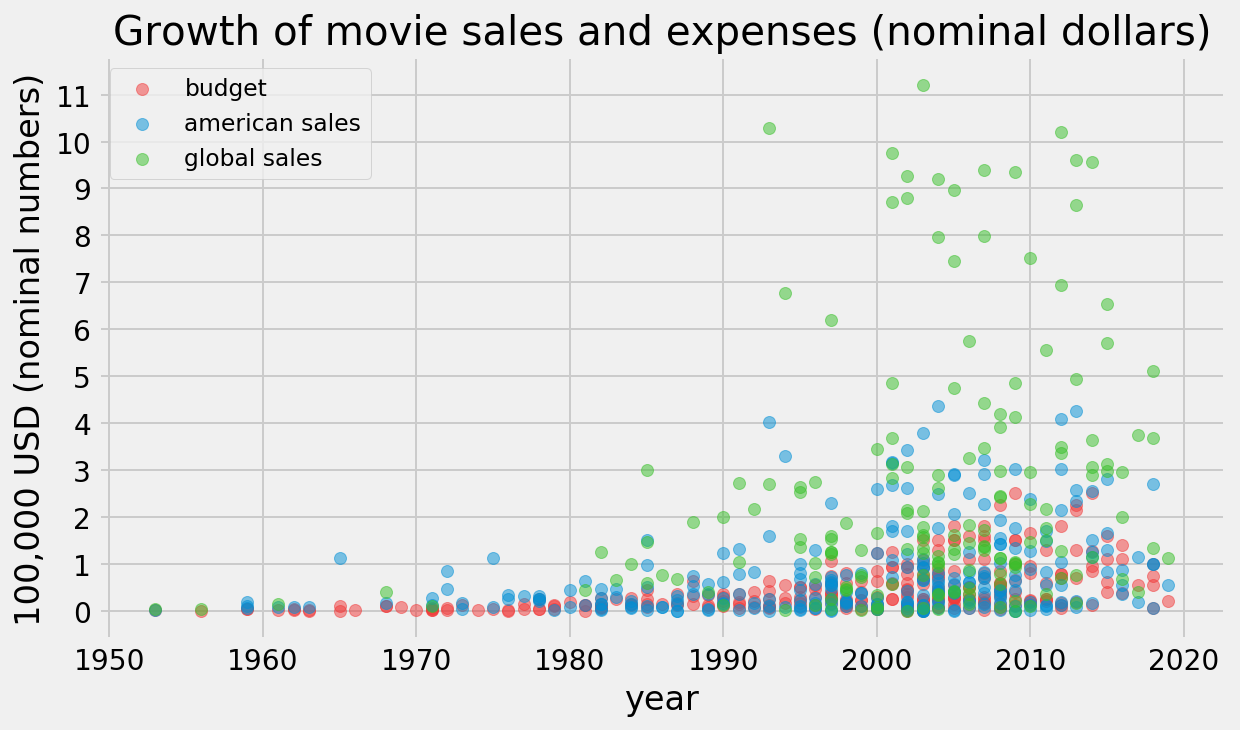

In [430]:
plt.figure(figsize=(9, 5))
plt.scatter(x=movies['imdb_year'], y=(movies['budget']),
            label='budget', c=RED, alpha=0.5)
plt.scatter(x=movies['imdb_year'], y=(
    movies['gross_usa']), label='american sales', alpha=0.5)
plt.scatter(x=movies['imdb_year'], y=(movies['cumulative_worldwide_gross']),
            label='global sales', alpha=0.5, c=MEAN_COL)
plt.title('Growth of movie sales and expenses (nominal dollars)')
plt.yticks(np.arange(0, 1200000000, 100000000), labels=range(0, 12))
plt.ylabel("100,000 USD (nominal numbers)")
plt.xlabel('year')
plt.legend(fontsize = 'small')
plt.show()

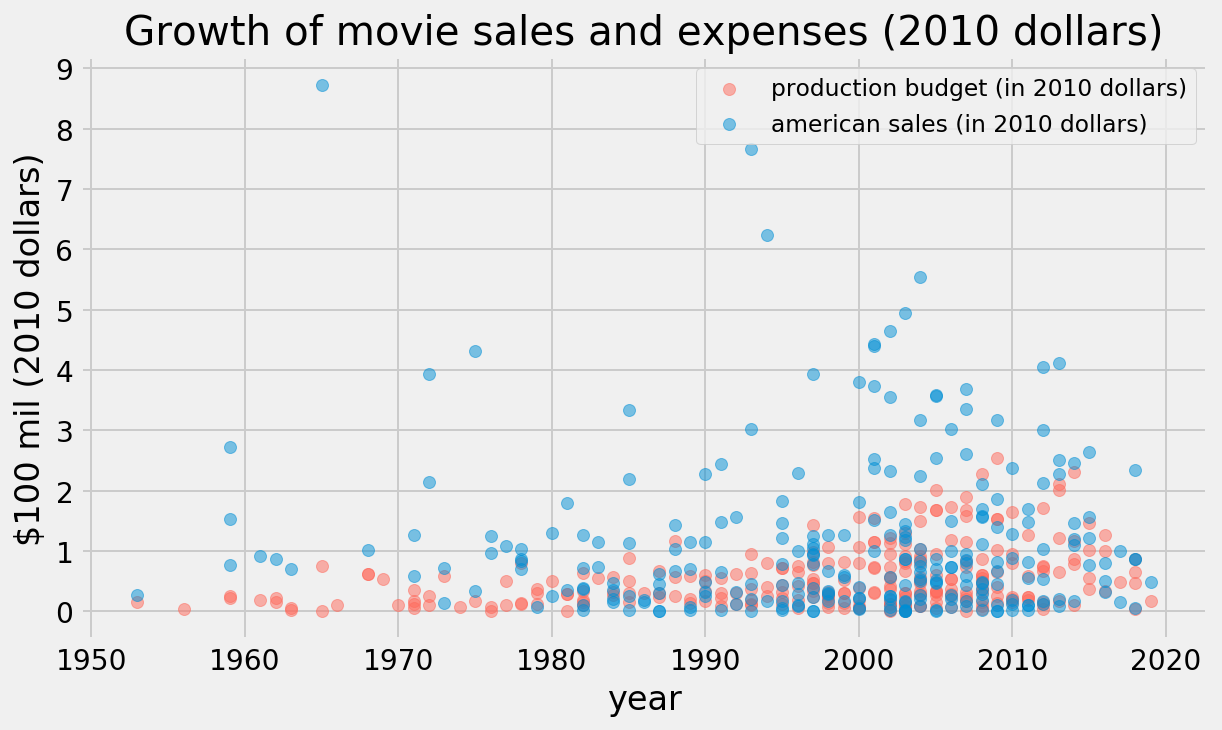

In [162]:
plt.figure(figsize=(9, 5))
plt.scatter(x=movies['imdb_year'], y=(movies['budget_2010_dollars']),
            label='production budget (in 2010 dollars)', c=MED_COL, alpha=0.5)
plt.scatter(x=movies['imdb_year'], y=(
    movies['gross_usa_2010_dollars']), label='american sales (in 2010 dollars)', alpha=0.5)
plt.title('Growth of movie sales and expenses (2010 dollars)')
plt.yticks(np.arange(0, 1000000000, 100000000), labels=range(0, 12))
plt.ylabel("$100 mil (2010 dollars)")
plt.xlabel('year')
plt.legend(fontsize = 'small')
plt.show()

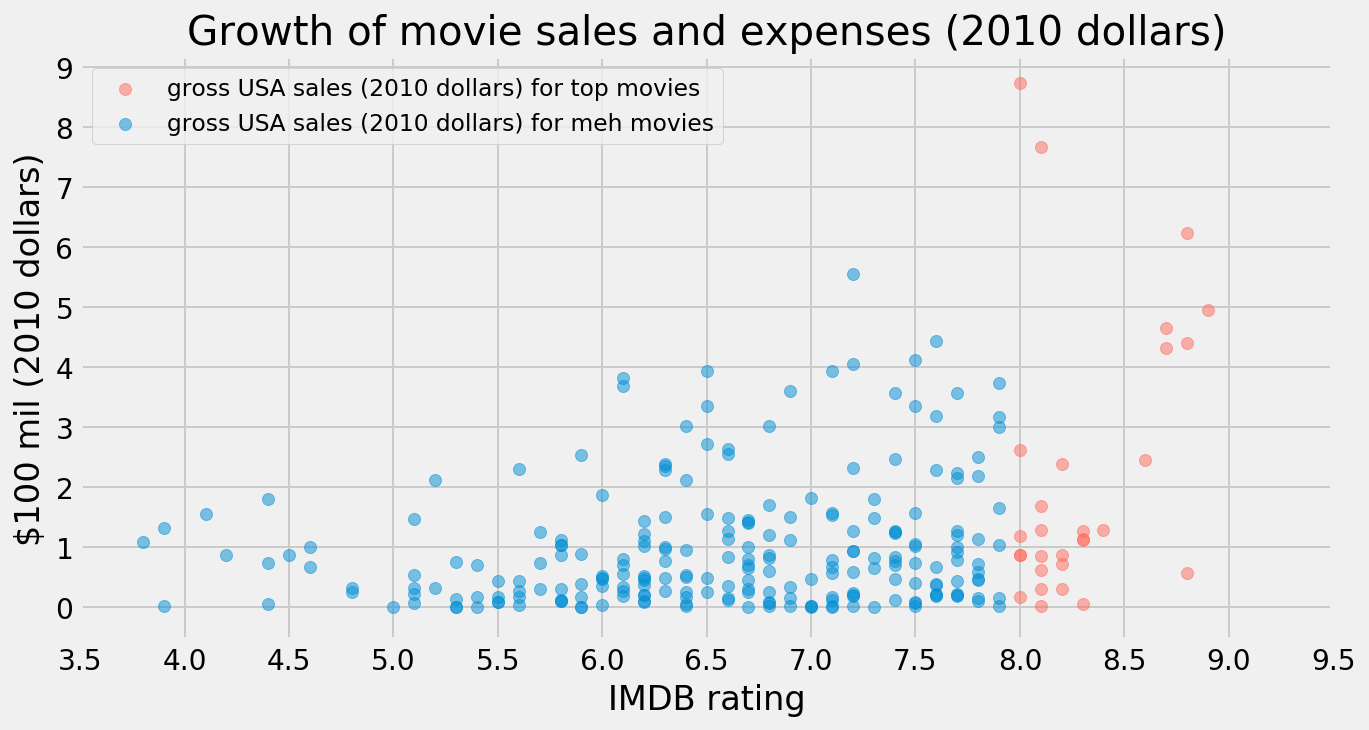

In [161]:
plt.figure(figsize=(10, 5))
plt.scatter(x=top_movies['imdb_imdbrating'], y=(top_movies['gross_usa_2010_dollars']),
            label='gross USA sales (2010 dollars) for top movies', c=MED_COL, alpha=0.5)
plt.scatter(x=meh_movies['imdb_imdbrating'], y=(
    meh_movies['gross_usa_2010_dollars']), label='gross USA sales (2010 dollars) for meh movies', alpha=0.5)
plt.yticks(np.arange(0, 1000000000, 100000000), labels=range(0, 12))
plt.ylabel("$100 mil (2010 dollars)")
plt.title('Growth of movie sales and expenses (2010 dollars)')
plt.xlabel('IMDB rating')
plt.xticks(np.arange(3.5, 10, 0.5))
plt.legend(fontsize = 'small')
plt.show()

In [483]:
genres = movies.explode('imdb_genres')
genres = genres[['movie_title', 'imdb_genres', 'imdb_year',
                 'imdb_imdbrating', 'gross_usa_2010_dollars', 'cumulative_worldwide_gross']]
genres.dropna(inplace=True, subset=['movie_title', 'imdb_genres', 'imdb_year',
                                    'imdb_imdbrating', 'gross_usa_2010_dollars'])

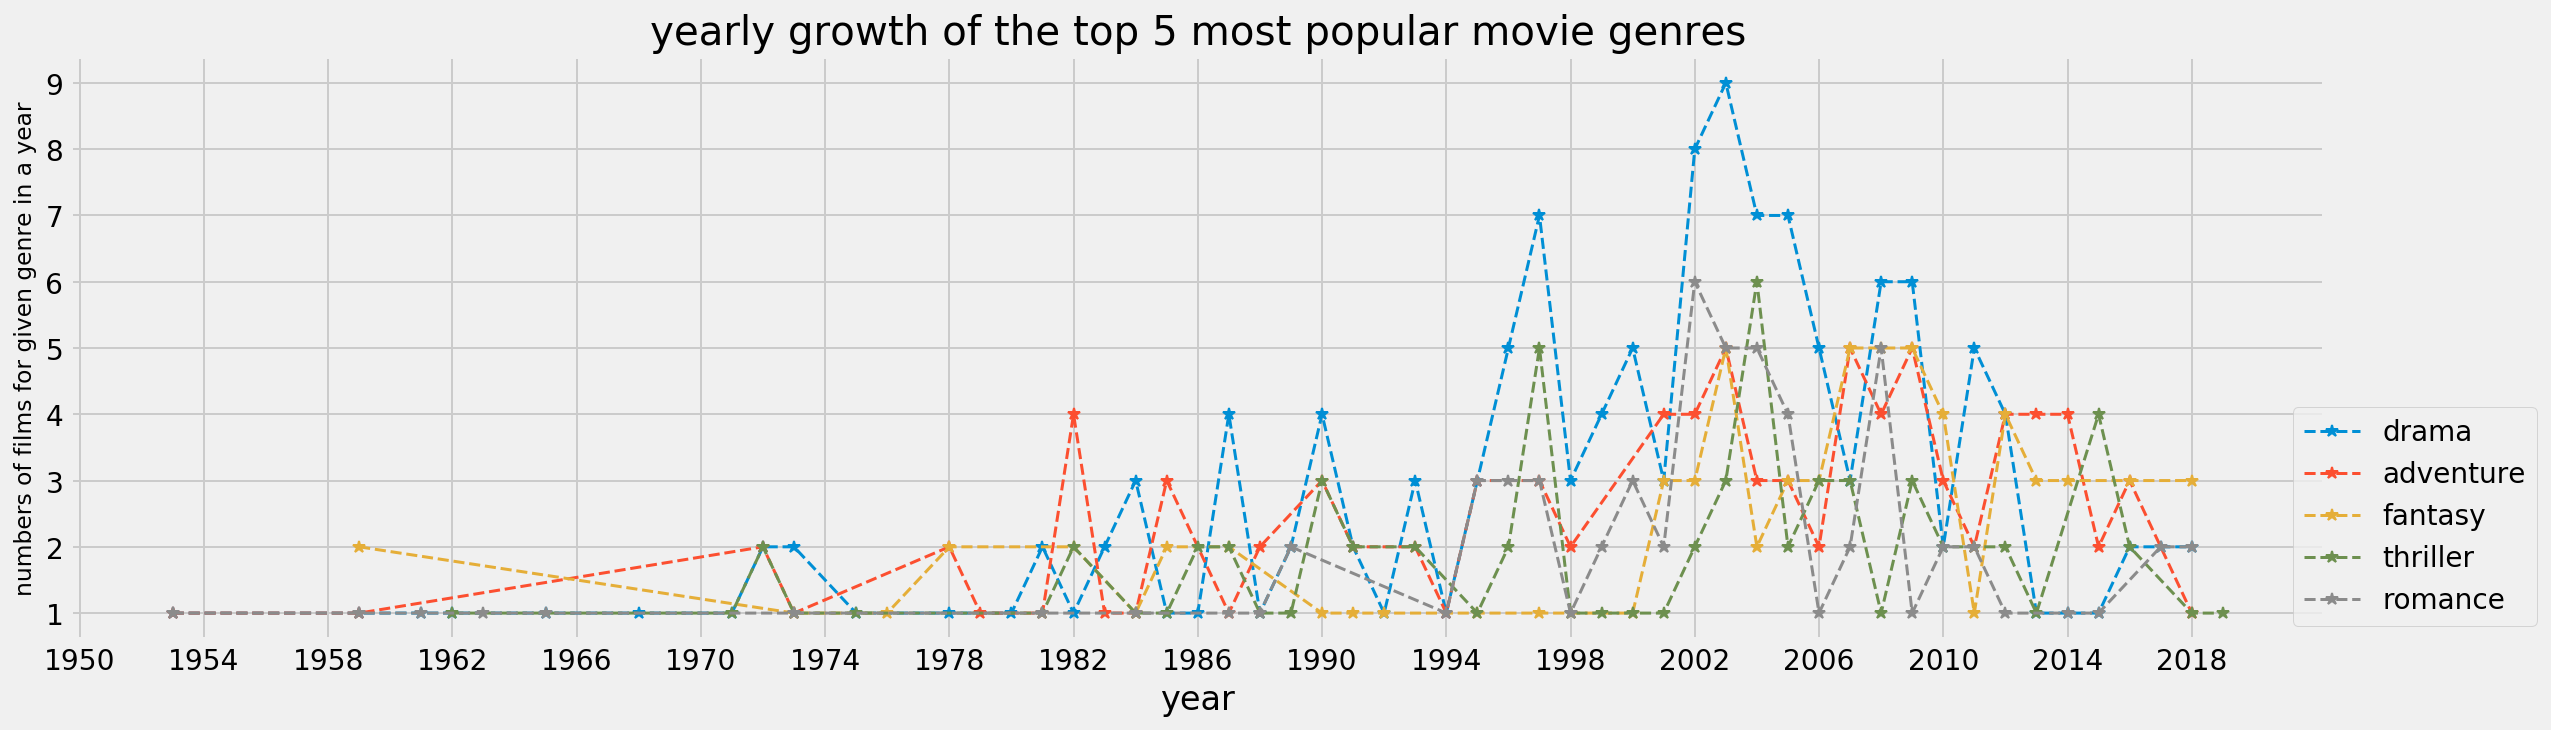

In [484]:
plt.figure(figsize=(18, 5))
for g in genres['imdb_genres'].value_counts()[:5].index:
    g_select = genres.loc[genres['imdb_genres'] == g]
    vc = g_select['imdb_year'].value_counts(dropna = True).sort_index()
    x = list(vc.index)
    y = list(vc.values)
    plt.plot(x, y, '--*', lw=1.5, label = g)

plt.ylabel('numbers of films for given genre in a year', fontsize = 'small')
plt.xlabel('year')
plt.yticks(range(1, 10))
plt.xticks(range(1950, 2020, 4))
plt.legend(loc = 4, bbox_to_anchor=(1.1, 0))
plt.title('yearly growth of the top 5 most popular movie genres')
plt.show()

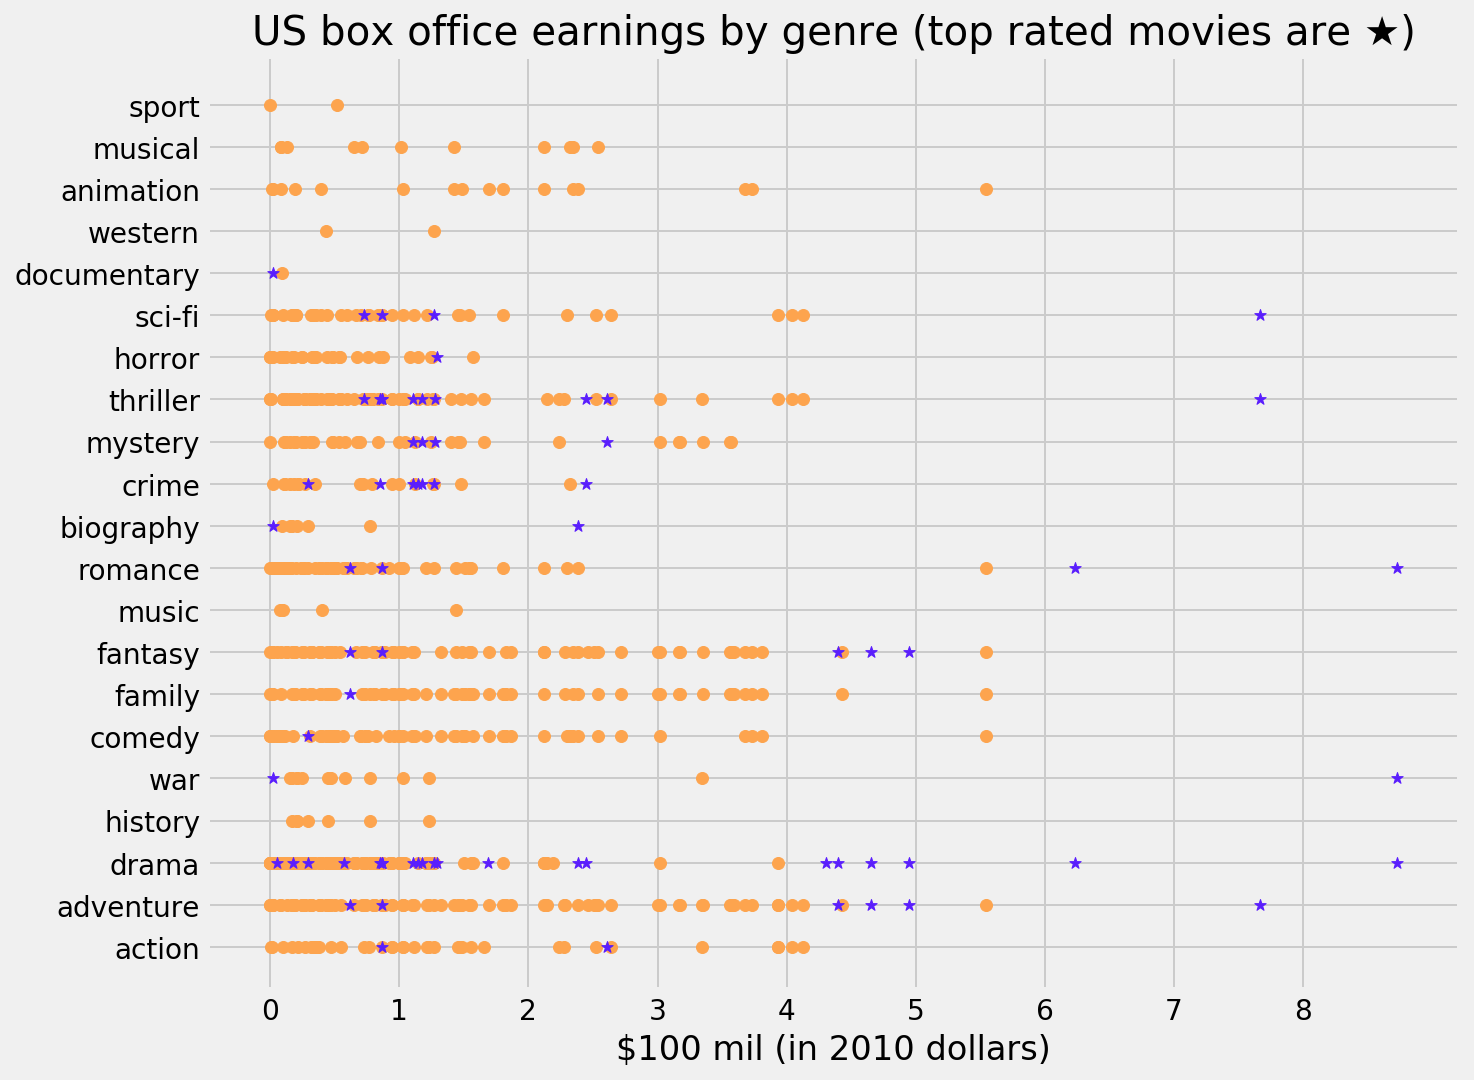

In [486]:
t_genres = genres.loc[genres['imdb_imdbrating'] >= 8]
m_genres = genres.loc[genres['imdb_imdbrating'] < 8]

plt.figure(figsize=(10, 8))

for g in genres['imdb_genres'].unique(): 
    m_g_select = m_genres.loc[m_genres['imdb_genres'] == g]
    plt.scatter(y=m_g_select['imdb_genres'],
                x=m_g_select['gross_usa_2010_dollars'], color = ORANGE)
    
    t_g_select = t_genres.loc[t_genres['imdb_genres'] == g]
    plt.scatter(y=t_g_select['imdb_genres'],
                x=t_g_select['gross_usa_2010_dollars'], color = VIOLET, marker= '*')

plt.xticks(np.arange(0, 900000000, 100000000), labels=range(0, 12))
plt.xlabel("$100 mil (in 2010 dollars)")
plt.title('US box office earnings by genre (top rated movies are ★)')
plt.show()

In [487]:
vc = genres['imdb_genres'].value_counts() > 5
vc_true = [g for g in vc.index if vc[g] != False]
genres_2 = genres.loc[genres['imdb_genres'].isin(vc_true)]
x = genres_2.groupby(by='imdb_genres').median()

x.sort_values(by = 'imdb_imdbrating', ascending = False)[:5]

,imdb_year,imdb_imdbrating,gross_usa_2010_dollars,cumulative_worldwide_gross
imdb_genres,,,,
biography,2003.00,7.45,19029087.61,78269970.00
war,1994.00,7.40,45909306.81,129266061.00
history,2003.00,7.40,29466985.71,72484985.00
crime,1997.00,7.35,81989639.54,102908091.50
drama,2001.00,7.10,47391644.64,113019290.00


In [488]:
x.sort_values(by = 'gross_usa_2010_dollars', ascending = False)[:5]

,imdb_year,imdb_imdbrating,gross_usa_2010_dollars,cumulative_worldwide_gross
imdb_genres,,,,
animation,2005.50,6.75,159165242.38,497987283.00
family,2004.50,6.50,110831580.43,316199152.00
action,2004.00,6.30,103100980.81,213022667.50
adventure,2003.00,6.60,103100980.81,298838380.50
mystery,2002.50,7.00,102495511.45,152483380.50


In [491]:
x.sort_values(by = 'cumulative_worldwide_gross', ascending = False)[:5]

,imdb_year,imdb_imdbrating,gross_usa_2010_dollars,cumulative_worldwide_gross
imdb_genres,,,,
animation,2005.50,6.75,159165242.38,497987283.00
fantasy,2006.00,6.50,99982780.72,345141403.00
family,2004.50,6.50,110831580.43,316199152.00
musical,2004.00,6.40,101204819.28,306776732.00
adventure,2003.00,6.60,103100980.81,298838380.50


## MERGE ALL

In [674]:
25/3

8.333333333333334

In [677]:
(8.3 ** 2) / 4.27 * np.log(129)

78.40573220994747

/Users/chan/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:202: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



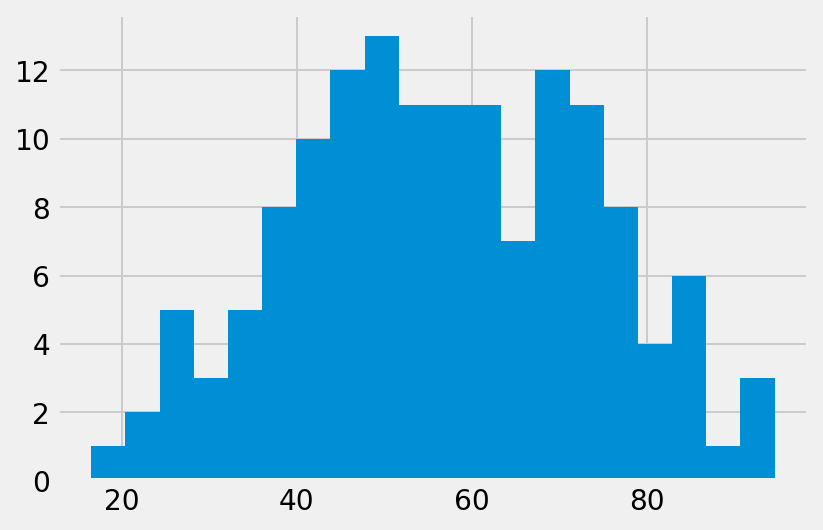

In [654]:
merged = movies.merge(books, on='book_id')
merged.dropna(subset=['imdb_imdbrating', 'gc_average_rating',
                      'gross_usa_2010_dollars'], inplace=True)
merged['time_between_book_and_movie'] = merged['imdb_year'] - \
    merged['publish_year']
merged['time_between_book_and_movie'].loc[merged['time_between_book_and_movie'] < 0] = -1

merged['must_see'] = (merged['imdb_imdbrating'] ** 2 /
                      merged['gc_average_rating']) * (np.log(merged['imdb_runtime']))

merged['must_see'].hist(bins=20)

In [660]:
np.percentile(merged['must_see'], 80)

72.93787929178929

In [655]:
merged['must_see'].describe()

count   144.00
mean     56.72
std      16.88
min      16.53
25%      44.41
50%      55.75
75%      70.45
max      94.53
Name: must_see, dtype: float64

In [668]:
merged_important = ['movie_title', 'book_title_x', 'imdb_year', 'must_see', 
                    'imdb_imdbrating', 'gc_average_rating', 'gross_usa_2010_dollars']

In [661]:
must_see_rated = merged.query('must_see >= 72.9')
not_must_see_rated = merged.query('must_see < 72.9')

must_see_rated.shape, not_must_see_rated.shape

((29, 47), (115, 47))

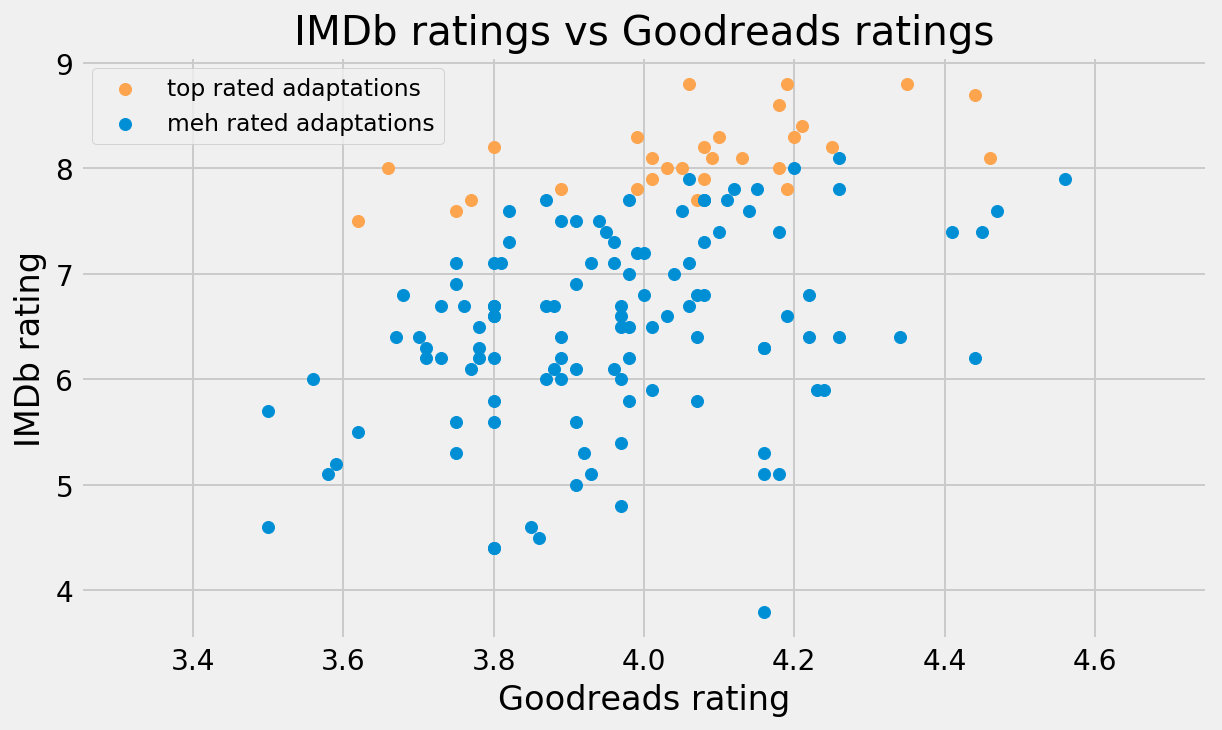

In [662]:
plt.figure(figsize=(9, 5))
plt.scatter(x=must_see_rated['gc_average_rating'], y=must_see_rated['imdb_imdbrating'],
            color=ORANGE, label='top rated adaptations')
plt.scatter(x=not_must_see_rated['gc_average_rating'],
            y=not_must_see_rated['imdb_imdbrating'], label='meh rated adaptations')
plt.title('IMDb ratings vs Goodreads ratings')
plt.xlabel('Goodreads rating')
plt.xlim([3.25, 4.75])
plt.ylabel('IMDb rating')
plt.legend(fontsize = 'small')
plt.show()

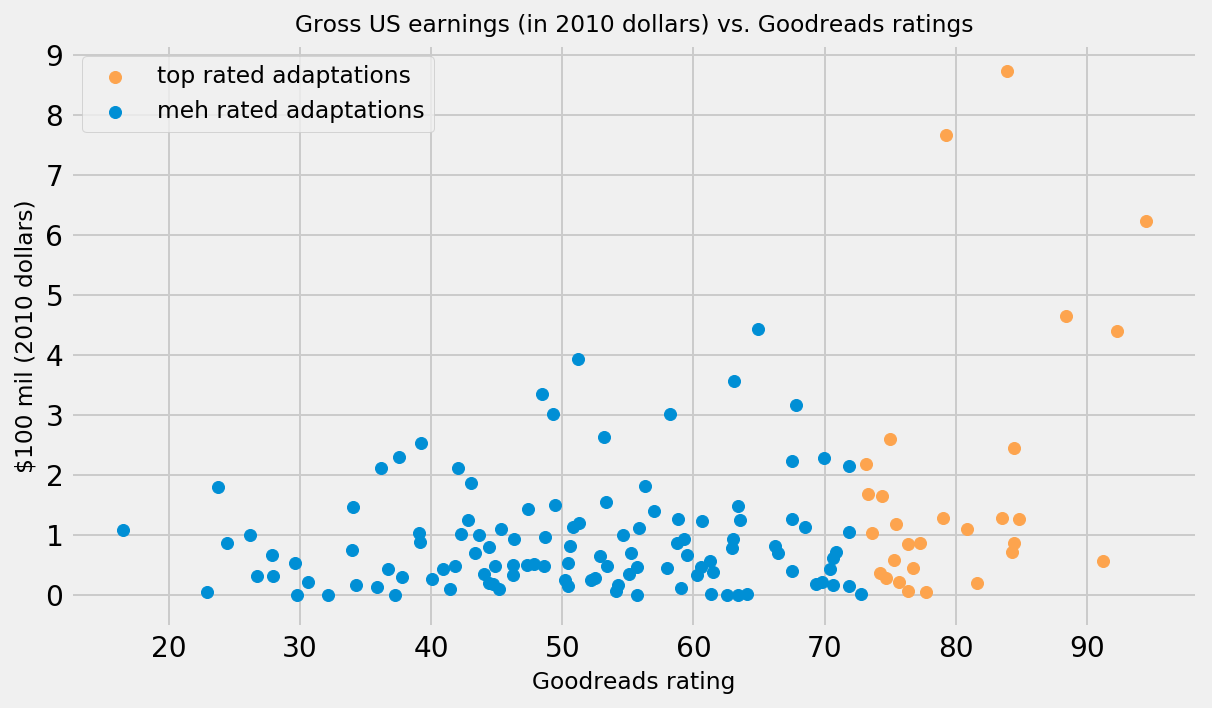

In [663]:
plt.figure(figsize=(9, 5))
plt.scatter(x=must_see_rated['must_see'], y=must_see_rated['gross_usa_2010_dollars'],
            color=ORANGE, label='top rated adaptations')
plt.scatter(x=not_must_see_rated['must_see'],
            y=not_must_see_rated['gross_usa_2010_dollars'], label='meh rated adaptations')
plt.title('Gross US earnings (in 2010 dollars) vs. Goodreads ratings', fontsize='small')
plt.yticks(np.arange(0, 1000000000, 100000000), labels=range(0, 12))
plt.ylabel("$100 mil (2010 dollars)", fontsize = 'small')
plt.xlabel('Goodreads rating', fontsize = 'small')
plt.legend(fontsize = 'small')
plt.show()

In [670]:
merged[merged_important].loc[merged['must_see'] > 72.9].sort_values(by = 'must_see', ascending = False)

,movie_title,book_title_x,imdb_year,must_see,imdb_imdbrating,gc_average_rating,gross_usa_2010_dollars
426,forrest gump,forrest gump_(novel),1994.00,94.53,8.80,4.06,623117324.53
180,the lord of the rings: the fellowship of the ring,the fellowship of the ring,2001.00,92.25,8.80,4.35,440090306.83
53,fight club,fight club_(novel),1999.00,91.20,8.80,4.19,57500158.39
332,the lord of the rings: the two towers,the two towers,2002.00,88.43,8.70,4.44,465423050.27
431,a clockwork orange (film),a clockwork orange_(novel),1971.00,84.82,8.30,3.99,127221794.26
17,big fish,big fish_(novel),2003.00,84.43,8.00,3.66,86723824.61
291,the silence of the lambs,the silence of the lambs_(novel),1991.00,84.41,8.60,4.18,244836932.58
287,blade runner,blade runner,1982.00,84.27,8.20,3.80,72386058.98
312,doctor zhivago (1965 film),doctor zhivago (novel),1965.00,83.90,8.00,4.03,872828125.00
263,the shining (film),the shining_(novel),1980.00,83.53,8.40,4.21,129083208.21
